In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
pd.options.display.float_format = '{:.5f}'.format

# 데이터 불러오기

In [2]:
train = pd.read_csv('C:/dacon/train.csv')
test = pd.read_csv('C:/dacon/test.csv')
submission = pd.read_csv('C:/dacon/sample_submission.csv')
car_2020 = pd.read_csv('C:/dacon/car_2020.csv',encoding='cp949')


In [3]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72000,134,38.00000,A,15667000,103680,0.00000,3.00000,1425.00000,1015.00000
1,C2483,900,아파트,경상북도,국민임대,39.72000,15,38.00000,A,15667000,103680,0.00000,3.00000,1425.00000,1015.00000
2,C2483,900,아파트,경상북도,국민임대,51.93000,385,38.00000,A,27304000,184330,0.00000,3.00000,1425.00000,1015.00000
3,C2483,900,아파트,경상북도,국민임대,51.93000,15,38.00000,A,27304000,184330,0.00000,3.00000,1425.00000,1015.00000
4,C2483,900,아파트,경상북도,국민임대,51.93000,41,38.00000,A,27304000,184330,0.00000,3.00000,1425.00000,1015.00000


In [4]:
a = pd.qcut(train['총세대수'],3,labels=[1,2,3]) # 소단지,중단지,대단지
train.insert(14,'단지규모',a)

In [5]:
train['총세대수'] = np.log(train['총세대수'])
test['총세대수'] = np.log(test['총세대수'])

car_2020 = car_2020.drop(['시군구(1)'], axis=1)
car_2020.columns = ['지역','월','항목','분류','자동차수']
car_2020['월'] = pd.to_datetime(car_2020['월']).dt.month
car_2020.head()

In [6]:
train.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    211
도보 10분거리 내 버스정류장 수                4
단지내주차면수                           0
단지규모                              0
등록차량수                             0
dtype: int64

In [7]:
test.loc[test.단지코드.isin(['C2411']) & test.자격유형.isnull(), '자격유형'] = 'A'
test.loc[test.단지코드.isin(['C2253']) & test.자격유형.isnull(), '자격유형'] = 'C'

train.loc[train.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'
test.loc[test.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'

train.loc[train.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'
test.loc[test.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'

train.loc[train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
test.loc[test.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'

pd.concat([train.자격유형.value_counts(),
           test.자격유형.value_counts()], axis=1)

,자격유형,자격유형
A,1801,573
D,569,180
국민임대/장기전세_공급대상,222,103
행복주택_공급대상,213,124
영구임대_공급대상,147,42


In [8]:
train_copy = train.copy()
train_copy = pd.get_dummies(train_copy,columns=['자격유형'])
del train_copy['등록차량수']
train_copy['등록차량수'] = train['등록차량수']
train = train_copy

In [9]:
train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,단지규모,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,등록차량수
0,C2483,6.80239,아파트,경상북도,국민임대,39.72000,134,38.00000,15667000,103680,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
1,C2483,6.80239,아파트,경상북도,국민임대,39.72000,15,38.00000,15667000,103680,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
2,C2483,6.80239,아파트,경상북도,국민임대,51.93000,385,38.00000,27304000,184330,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
3,C2483,6.80239,아파트,경상북도,국민임대,51.93000,15,38.00000,27304000,184330,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
4,C2483,6.80239,아파트,경상북도,국민임대,51.93000,41,38.00000,27304000,184330,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,C2532,5.47646,아파트,강원도,국민임대,49.20000,19,7.00000,11346000,116090,0.00000,1.00000,166.00000,1,1,0,0,0,0,146.00000
2948,C2532,5.47646,아파트,강원도,국민임대,51.08000,34,7.00000,14005000,142310,0.00000,1.00000,166.00000,1,1,0,0,0,0,146.00000
2949,C2532,5.47646,아파트,강원도,국민임대,51.73000,34,7.00000,14005000,142310,0.00000,1.00000,166.00000,1,1,0,0,0,0,146.00000
2950,C2532,5.47646,아파트,강원도,국민임대,51.96000,114,7.00000,14005000,142310,0.00000,1.00000,166.00000,1,1,0,0,0,0,146.00000


# 컬럼명 바꿔주기

In [10]:
train.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '단지규모', 'A', 'D', '국민임대/장기전세', '영구임대', '행복주택', '등록차량수'
]

In [11]:
train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,임대보증금,임대료,지하철,버스,단지내주차면수,단지규모,A,D,국민임대/장기전세,영구임대,행복주택,등록차량수
0,C2483,6.80239,아파트,경상북도,국민임대,39.72000,134,38.00000,15667000,103680,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
1,C2483,6.80239,아파트,경상북도,국민임대,39.72000,15,38.00000,15667000,103680,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
2,C2483,6.80239,아파트,경상북도,국민임대,51.93000,385,38.00000,27304000,184330,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
3,C2483,6.80239,아파트,경상북도,국민임대,51.93000,15,38.00000,27304000,184330,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
4,C2483,6.80239,아파트,경상북도,국민임대,51.93000,41,38.00000,27304000,184330,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,C2532,5.47646,아파트,강원도,국민임대,49.20000,19,7.00000,11346000,116090,0.00000,1.00000,166.00000,1,1,0,0,0,0,146.00000
2948,C2532,5.47646,아파트,강원도,국민임대,51.08000,34,7.00000,14005000,142310,0.00000,1.00000,166.00000,1,1,0,0,0,0,146.00000
2949,C2532,5.47646,아파트,강원도,국민임대,51.73000,34,7.00000,14005000,142310,0.00000,1.00000,166.00000,1,1,0,0,0,0,146.00000
2950,C2532,5.47646,아파트,강원도,국민임대,51.96000,114,7.00000,14005000,142310,0.00000,1.00000,166.00000,1,1,0,0,0,0,146.00000


# 지하철 Y or N로 변경

In [12]:
train['지하철'] = train['지하철'].fillna(0)
train['지하철'] = np.where(train['지하철'] == 0, 0, 1)

# 결측치 처리

In [13]:
train.loc[train.임대보증금=='-', '임대보증금'] = np.nan
train.loc[train.임대료=='-', '임대료'] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
train['임대료'] = train['임대료'].astype(float)
train['임대보증금'] = train['임대보증금'].fillna(0)
train['임대료'] = train['임대료'].fillna(0)

In [14]:
train['버스'] = train['버스'].fillna(train['버스'].mean())

In [15]:
train.isnull().sum()

단지코드         0
총세대수         0
임대건물구분       0
지역           0
공급유형         0
전용면적         0
전용면적별세대수     0
공가수          0
임대보증금        0
임대료          0
지하철          0
버스           0
단지내주차면수      0
단지규모         0
A            0
D            0
국민임대/장기전세    0
영구임대         0
행복주택         0
등록차량수        0
dtype: int64

# 임대건물구분 : 아파트->상가 / 전용면적별세대수 : x->1

In [16]:
idx = train[(train['임대건물구분']=='아파트') & (train['D']=='D')]['전용면적별세대수'].index
train.loc[idx, '전용면적별세대수'] = 1
train.loc[idx, '임대건물구분'] = '상가'

In [17]:
# 원핫 인코딩
#train = pd.get_dummies(data = train, columns = ['지하철'])

# 지역명 숫자로 매핑

In [18]:
local_map = {}
for i, loc in enumerate(train['지역'].unique()):
    local_map[loc] = i
    
train['지역'] = train['지역'].map(local_map)

# 전용면적을 5의 배수로 변경

In [19]:
train['전용면적'] = train['전용면적']//5*5

# 전용면적 상/하한 적용

In [20]:
idx = train[train['전용면적']>100].index
train.loc[idx, '전용면적'] = 100

idx = train[train['전용면적']<15].index
train.loc[idx, '전용면적'] = 15

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   단지코드       2952 non-null   object  
 1   총세대수       2952 non-null   float64 
 2   임대건물구분     2952 non-null   object  
 3   지역         2952 non-null   int64   
 4   공급유형       2952 non-null   object  
 5   전용면적       2952 non-null   float64 
 6   전용면적별세대수   2952 non-null   int64   
 7   공가수        2952 non-null   float64 
 8   임대보증금      2952 non-null   float64 
 9   임대료        2952 non-null   float64 
 10  지하철        2952 non-null   int32   
 11  버스         2952 non-null   float64 
 12  단지내주차면수    2952 non-null   float64 
 13  단지규모       2952 non-null   category
 14  A          2952 non-null   uint8   
 15  D          2952 non-null   uint8   
 16  국민임대/장기전세  2952 non-null   uint8   
 17  영구임대       2952 non-null   uint8   
 18  행복주택       2952 non-null   uint8   
 19  등록차량수      2952 non-null   

# test 불러오기

In [22]:
a = pd.qcut(test['총세대수'],3,labels=[1,2,3]) # 소단지,중단지,대단지
test.insert(14,'단지규모',a)

In [23]:
test_copy = test.copy()
test_copy = pd.get_dummies(test_copy,columns=['자격유형'])
test = test_copy

In [24]:
test

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,단지규모,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상
0,C1072,6.62539,아파트,경기도,국민임대,39.79000,116,14.00000,22830000,189840,0.00000,2.00000,683.00000,2,0,0,1,0,0
1,C1072,6.62539,아파트,경기도,국민임대,46.81000,30,14.00000,36048000,249930,0.00000,2.00000,683.00000,2,1,0,0,0,0
2,C1072,6.62539,아파트,경기도,국민임대,46.90000,112,14.00000,36048000,249930,0.00000,2.00000,683.00000,2,0,0,1,0,0
3,C1072,6.62539,아파트,경기도,국민임대,46.90000,120,14.00000,36048000,249930,0.00000,2.00000,683.00000,2,0,0,1,0,0
4,C1072,6.62539,아파트,경기도,국민임대,51.46000,60,14.00000,43497000,296780,0.00000,2.00000,683.00000,2,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,C1267,6.51471,아파트,경상남도,행복주택,36.77000,126,38.00000,-,-,0.00000,1.00000,467.00000,2,0,0,0,0,1
1018,C2189,5.94542,아파트,전라북도,국민임대,29.19000,96,45.00000,6872000,106400,0.00000,2.00000,300.00000,1,0,0,1,0,0
1019,C2189,5.94542,아파트,전라북도,국민임대,29.19000,20,45.00000,6872000,106400,0.00000,2.00000,300.00000,1,0,0,1,0,0
1020,C2189,5.94542,아파트,전라북도,국민임대,39.45000,202,45.00000,13410000,144600,0.00000,2.00000,300.00000,1,0,0,1,0,0


In [25]:
test.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '단지규모' , 'A', 'D', '국민임대/장기전세', '영구임대', '행복주택'
]

In [26]:
test.isnull().sum()

단지코드           0
총세대수           0
임대건물구분         0
지역             0
공급유형           0
전용면적           0
전용면적별세대수       0
공가수            0
임대보증금        180
임대료          180
지하철           42
버스             0
단지내주차면수        0
단지규모           0
A              0
D              0
국민임대/장기전세      0
영구임대           0
행복주택           0
dtype: int64

In [27]:
test.loc[test.임대보증금=='-', '임대보증금'] = np.nan
test.loc[test.임대료=='-', '임대료'] = np.nan
test['임대보증금'] = test['임대보증금'].fillna(0)
test['임대료'] = test['임대료'].fillna(0)
test['임대보증금'] = test['임대보증금'].astype(float)
test['임대료'] = test['임대료'].astype(float)

In [28]:
test['지하철'].value_counts()

0.00000    881
1.00000     64
2.00000     35
Name: 지하철, dtype: int64

In [29]:
test['지하철'] = test['지하철'].fillna(0)
test['지하철'] = np.where(test['지하철'] == 0, 0, 1)

In [30]:
test.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,임대보증금,임대료,지하철,버스,단지내주차면수,단지규모,A,D,국민임대/장기전세,영구임대,행복주택
0,C1072,6.62539,아파트,경기도,국민임대,39.79000,116,14.00000,22830000.00000,189840.00000,0,2.00000,683.00000,2,0,0,1,0,0
1,C1072,6.62539,아파트,경기도,국민임대,46.81000,30,14.00000,36048000.00000,249930.00000,0,2.00000,683.00000,2,1,0,0,0,0
2,C1072,6.62539,아파트,경기도,국민임대,46.90000,112,14.00000,36048000.00000,249930.00000,0,2.00000,683.00000,2,0,0,1,0,0
3,C1072,6.62539,아파트,경기도,국민임대,46.90000,120,14.00000,36048000.00000,249930.00000,0,2.00000,683.00000,2,0,0,1,0,0
4,C1072,6.62539,아파트,경기도,국민임대,51.46000,60,14.00000,43497000.00000,296780.00000,0,2.00000,683.00000,2,0,0,1,0,0


In [31]:
local_map = {}
for i, loc in enumerate(test['지역'].unique()):
    local_map[loc] = i
    
test['지역'] = test['지역'].map(local_map)

In [32]:
test['전용면적'] = test['전용면적']//5*5

idx = test[test['전용면적']>100].index
test.loc[idx, '전용면적'] = 100

idx = test[test['전용면적']<15].index
test.loc[idx, '전용면적'] = 15

In [33]:
test.isnull().sum()

단지코드         0
총세대수         0
임대건물구분       0
지역           0
공급유형         0
전용면적         0
전용면적별세대수     0
공가수          0
임대보증금        0
임대료          0
지하철          0
버스           0
단지내주차면수      0
단지규모         0
A            0
D            0
국민임대/장기전세    0
영구임대         0
행복주택         0
dtype: int64

In [34]:
columns = ['총세대수', '지역', '전용면적별세대수', '공가수', '지하철', '버스', '단지내주차면수', '단지규모']
target = '등록차량수'
area_columns = []
for area in train['전용면적'].unique():
    area_columns.append(f'면적_{area}')

In [35]:
new_train = pd.DataFrame()
new_test = pd.DataFrame()

In [36]:
new_train['임대보증금'] = 0
new_train['임대료'] = 0
new_test['임대보증금'] = 0
new_test['임대료'] = 0

## 수정한 코드

In [37]:
# Train Dataframe Set
# 미사용 열s - 임대건물구분, 공급유형, 자격유형 임대보증금, 임대료
for i, code in tqdm(enumerate(train['단지코드'].unique())):
    temp = train[train['단지코드']==code]
    temp.index = range(temp.shape[0]) # index 재설정
    for col in columns:
        new_train.loc[i, col] = temp.loc[0, col] # Fixed Data
    
    deposit_cost = []
    rental_cost = []

    for col in area_columns:
        area = float(col.split('_')[-1]) # 면적의 숫자를 float형으로 저장
        # '면적_10' 등의 열을 만들고 - 같은 전용면적들 끼리 전용면적별세대수의 합을 Value로 Cell에 입력
        new_train.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()
        
        try:
          deposit_cost.append(temp[temp['전용면적']==area]['임대보증금'][0])
          rental_cost.append(temp[temp['전용면적']==area]['임대료'][0])
        except KeyError as e:
          continue
    
    new_train.loc[i, '등록차량수'] = temp.loc[0, '등록차량수']
    # print(type(deposit_cost[0]))
    new_train.loc[i, '임대보증금'] = int(np.mean(deposit_cost))
    new_train.loc[i, '임대료'] = int(np.mean(rental_cost))

# Test DataFrame Set
# 미사용 열s - 임대건물구분, 공급유형, 자격유형 임대보증금, 임대료, 등록차량수
for i, code in tqdm(enumerate(test['단지코드'].unique())):
    temp = test[test['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_test.loc[i, col] = temp.loc[0, col]

    deposit_cost = []
    rental_cost = []
    
    for col in area_columns:
        area = float(col.split('_')[-1])
        new_test.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()
        
        try:
          deposit_cost.append(temp[temp['전용면적']==area]['임대보증금'][0])
          rental_cost.append(temp[temp['전용면적']==area]['임대료'][0])
        except KeyError as e:
          continue
          
    new_test.loc[i, '임대보증금'] = int(np.mean(deposit_cost))
    new_test.loc[i, '임대료'] = int(np.mean(rental_cost))


# 추가해볼 것 임대보증금 , 임대료 Column 만들고 평균

423it [00:08, 48.89it/s]
150it [00:02, 50.40it/s]


In [38]:
train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,임대보증금,임대료,지하철,버스,단지내주차면수,단지규모,A,D,국민임대/장기전세,영구임대,행복주택,등록차량수
0,C2483,6.80239,아파트,0,국민임대,35.00000,134,38.00000,15667000.00000,103680.00000,0,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
1,C2483,6.80239,아파트,0,국민임대,35.00000,15,38.00000,15667000.00000,103680.00000,0,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
2,C2483,6.80239,아파트,0,국민임대,50.00000,385,38.00000,27304000.00000,184330.00000,0,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
3,C2483,6.80239,아파트,0,국민임대,50.00000,15,38.00000,27304000.00000,184330.00000,0,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
4,C2483,6.80239,아파트,0,국민임대,50.00000,41,38.00000,27304000.00000,184330.00000,0,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,C2532,5.47646,아파트,5,국민임대,45.00000,19,7.00000,11346000.00000,116090.00000,0,1.00000,166.00000,1,1,0,0,0,0,146.00000
2948,C2532,5.47646,아파트,5,국민임대,50.00000,34,7.00000,14005000.00000,142310.00000,0,1.00000,166.00000,1,1,0,0,0,0,146.00000
2949,C2532,5.47646,아파트,5,국민임대,50.00000,34,7.00000,14005000.00000,142310.00000,0,1.00000,166.00000,1,1,0,0,0,0,146.00000
2950,C2532,5.47646,아파트,5,국민임대,50.00000,114,7.00000,14005000.00000,142310.00000,0,1.00000,166.00000,1,1,0,0,0,0,146.00000


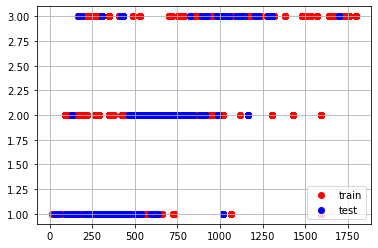

In [39]:
import matplotlib.pyplot as plt
plt.scatter(train['단지내주차면수'],train['단지규모'],c='red',label='train')
plt.scatter(test['단지내주차면수'],test['단지규모'],c='blue',label='test')
plt.legend()
plt.grid()
plt.show()

C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48124 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51076 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45380 missing from c

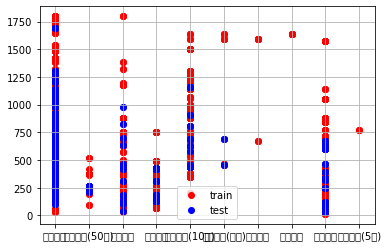

In [40]:
plt.scatter(train['공급유형'],train['단지내주차면수'],c='red',label='train')
plt.scatter(test['공급유형'],test['단지내주차면수'],c='blue',label='test')
plt.legend()
plt.grid()
plt.show()

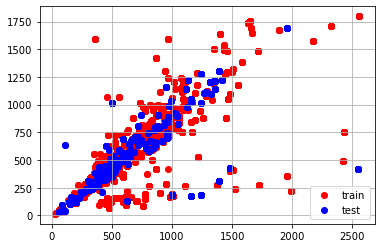

In [41]:
tttt=np.exp(train['총세대수'])-train['공가수']
test_t=np.exp(test['총세대수'])-test['공가수']
plt.scatter(tttt,train['단지내주차면수'],c='red',label='train')
plt.scatter(test_t,test['단지내주차면수'],c='blue',label='test')
plt.legend()
plt.grid()
plt.show()

In [42]:
tttt

0      862.00000
1      862.00000
2      862.00000
3      862.00000
4      862.00000
          ...   
2947   232.00000
2948   232.00000
2949   232.00000
2950   232.00000
2951   232.00000
Length: 2952, dtype: float64

In [43]:
train.corr()

,총세대수,지역,전용면적,전용면적별세대수,공가수,임대보증금,임대료,지하철,버스,단지내주차면수,A,D,국민임대/장기전세,영구임대,행복주택,등록차량수
총세대수,1.00000,-0.00512,-0.03382,0.13968,0.13072,-0.08732,-0.06187,0.21960,0.04661,0.55451,-0.23730,0.29806,0.09649,0.09567,-0.18587,0.38220
지역,-0.00512,1.00000,0.07388,-0.00258,0.01402,0.12207,0.14163,0.00629,-0.10980,0.00508,0.04190,-0.03306,-0.04048,-0.03289,0.04032,0.03826
전용면적,-0.03382,0.07388,1.00000,0.01474,-0.11491,0.44224,0.59232,-0.09099,0.01598,0.21655,0.43613,-0.21142,-0.04270,-0.21497,-0.27553,0.33420
전용면적별세대수,0.13968,-0.00258,0.01474,1.00000,0.16647,0.09240,0.15485,-0.05350,0.04710,0.28199,0.14926,-0.37034,0.11010,0.24163,-0.03211,0.24709
공가수,0.13072,0.01402,-0.11491,0.16647,1.00000,0.13592,-0.01011,-0.09023,0.04328,0.28982,0.00471,-0.24759,0.13308,-0.08719,0.30624,0.11812
임대보증금,-0.08732,0.12207,0.44224,0.09240,0.13592,1.00000,0.59560,-0.07528,0.08968,0.39055,0.26686,-0.47672,0.17911,-0.14285,0.16128,0.43607
임대료,-0.06187,0.14163,0.59232,0.15485,-0.01011,0.59560,1.00000,-0.06258,0.03571,0.40456,0.49239,-0.54492,0.04816,-0.10135,-0.06129,0.51983
지하철,0.21960,0.00629,-0.09099,-0.05350,-0.09023,-0.07528,-0.06258,1.00000,0.09749,-0.03749,-0.14217,0.20608,-0.06142,0.07939,-0.05032,-0.09980
버스,0.04661,-0.10980,0.01598,0.04710,0.04328,0.08968,0.03571,0.09749,1.00000,0.07063,0.00520,-0.00483,0.02992,0.00573,-0.03775,0.10372
단지내주차면수,0.55451,0.00508,0.21655,0.28199,0.28982,0.39055,0.40456,-0.03749,0.07063,1.00000,0.27501,-0.39088,0.22033,-0.08995,-0.07144,0.85922


In [44]:
x_train = new_train.iloc[:, :-1]
y_train = new_train.iloc[:,-1]
x_test = new_test

In [45]:
forest = RandomForestRegressor(n_jobs=-1, random_state=42)
forest.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [46]:
pred = forest.predict(x_test)
#pred

In [47]:
submission['num'] = pred

In [48]:
submission.to_csv('./신분OneHot.csv', index=False)

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
x = new_train.iloc[:, :-1]
y = new_train.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=0)
forest = RandomForestRegressor(random_state=0)
forest.fit(x_train, y_train)
pred = forest.predict(x_test)
mean_absolute_error(y_test, pred)

131.0185849056604

In [56]:
#Lasso Regression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
x = new_train.iloc[:, :-1]
y = new_train.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=0)
lasso=Lasso(alpha=0.1)
lasso.fit(x_train,y_train)
lasso_pred = lasso.predict(x_test)
mean_absolute_error(y_test,lasso_pred)

131.8588322172077

In [57]:
#Ridge Regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
x = new_train.iloc[:, :-1]
y = new_train.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=0)
ridge=Ridge(alpha=0.1)
ridge.fit(x_train,y_train)
ridge_pred = ridge.predict(x_test)
mean_absolute_error(y_test,ridge_pred)

C:\Users\namva\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.33164e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


131.9692393747529

In [59]:
#Naive bayes Regression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
x = new_train.iloc[:, :-1]
y = new_train.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=0)
naive=GaussianNB()
naive.fit(x_train,y_train)
naive_pred = naive.predict(x_test)
mean_absolute_error(y_test,naive_pred)

281.95283018867923

In [51]:
train.head(5)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,임대보증금,임대료,지하철,버스,단지내주차면수,단지규모,A,D,국민임대/장기전세,영구임대,행복주택,등록차량수
0,C2483,6.80239,아파트,0,국민임대,35.00000,134,38.00000,15667000.00000,103680.00000,0,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
1,C2483,6.80239,아파트,0,국민임대,35.00000,15,38.00000,15667000.00000,103680.00000,0,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
2,C2483,6.80239,아파트,0,국민임대,50.00000,385,38.00000,27304000.00000,184330.00000,0,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
3,C2483,6.80239,아파트,0,국민임대,50.00000,15,38.00000,27304000.00000,184330.00000,0,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
4,C2483,6.80239,아파트,0,국민임대,50.00000,41,38.00000,27304000.00000,184330.00000,0,3.00000,1425.00000,2,1,0,0,0,0,1015.00000


C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 52509 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49464 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50669 missing from c

C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47732 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51201 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50857 missing from cur

C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54665 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\namva\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48373 missing from curre

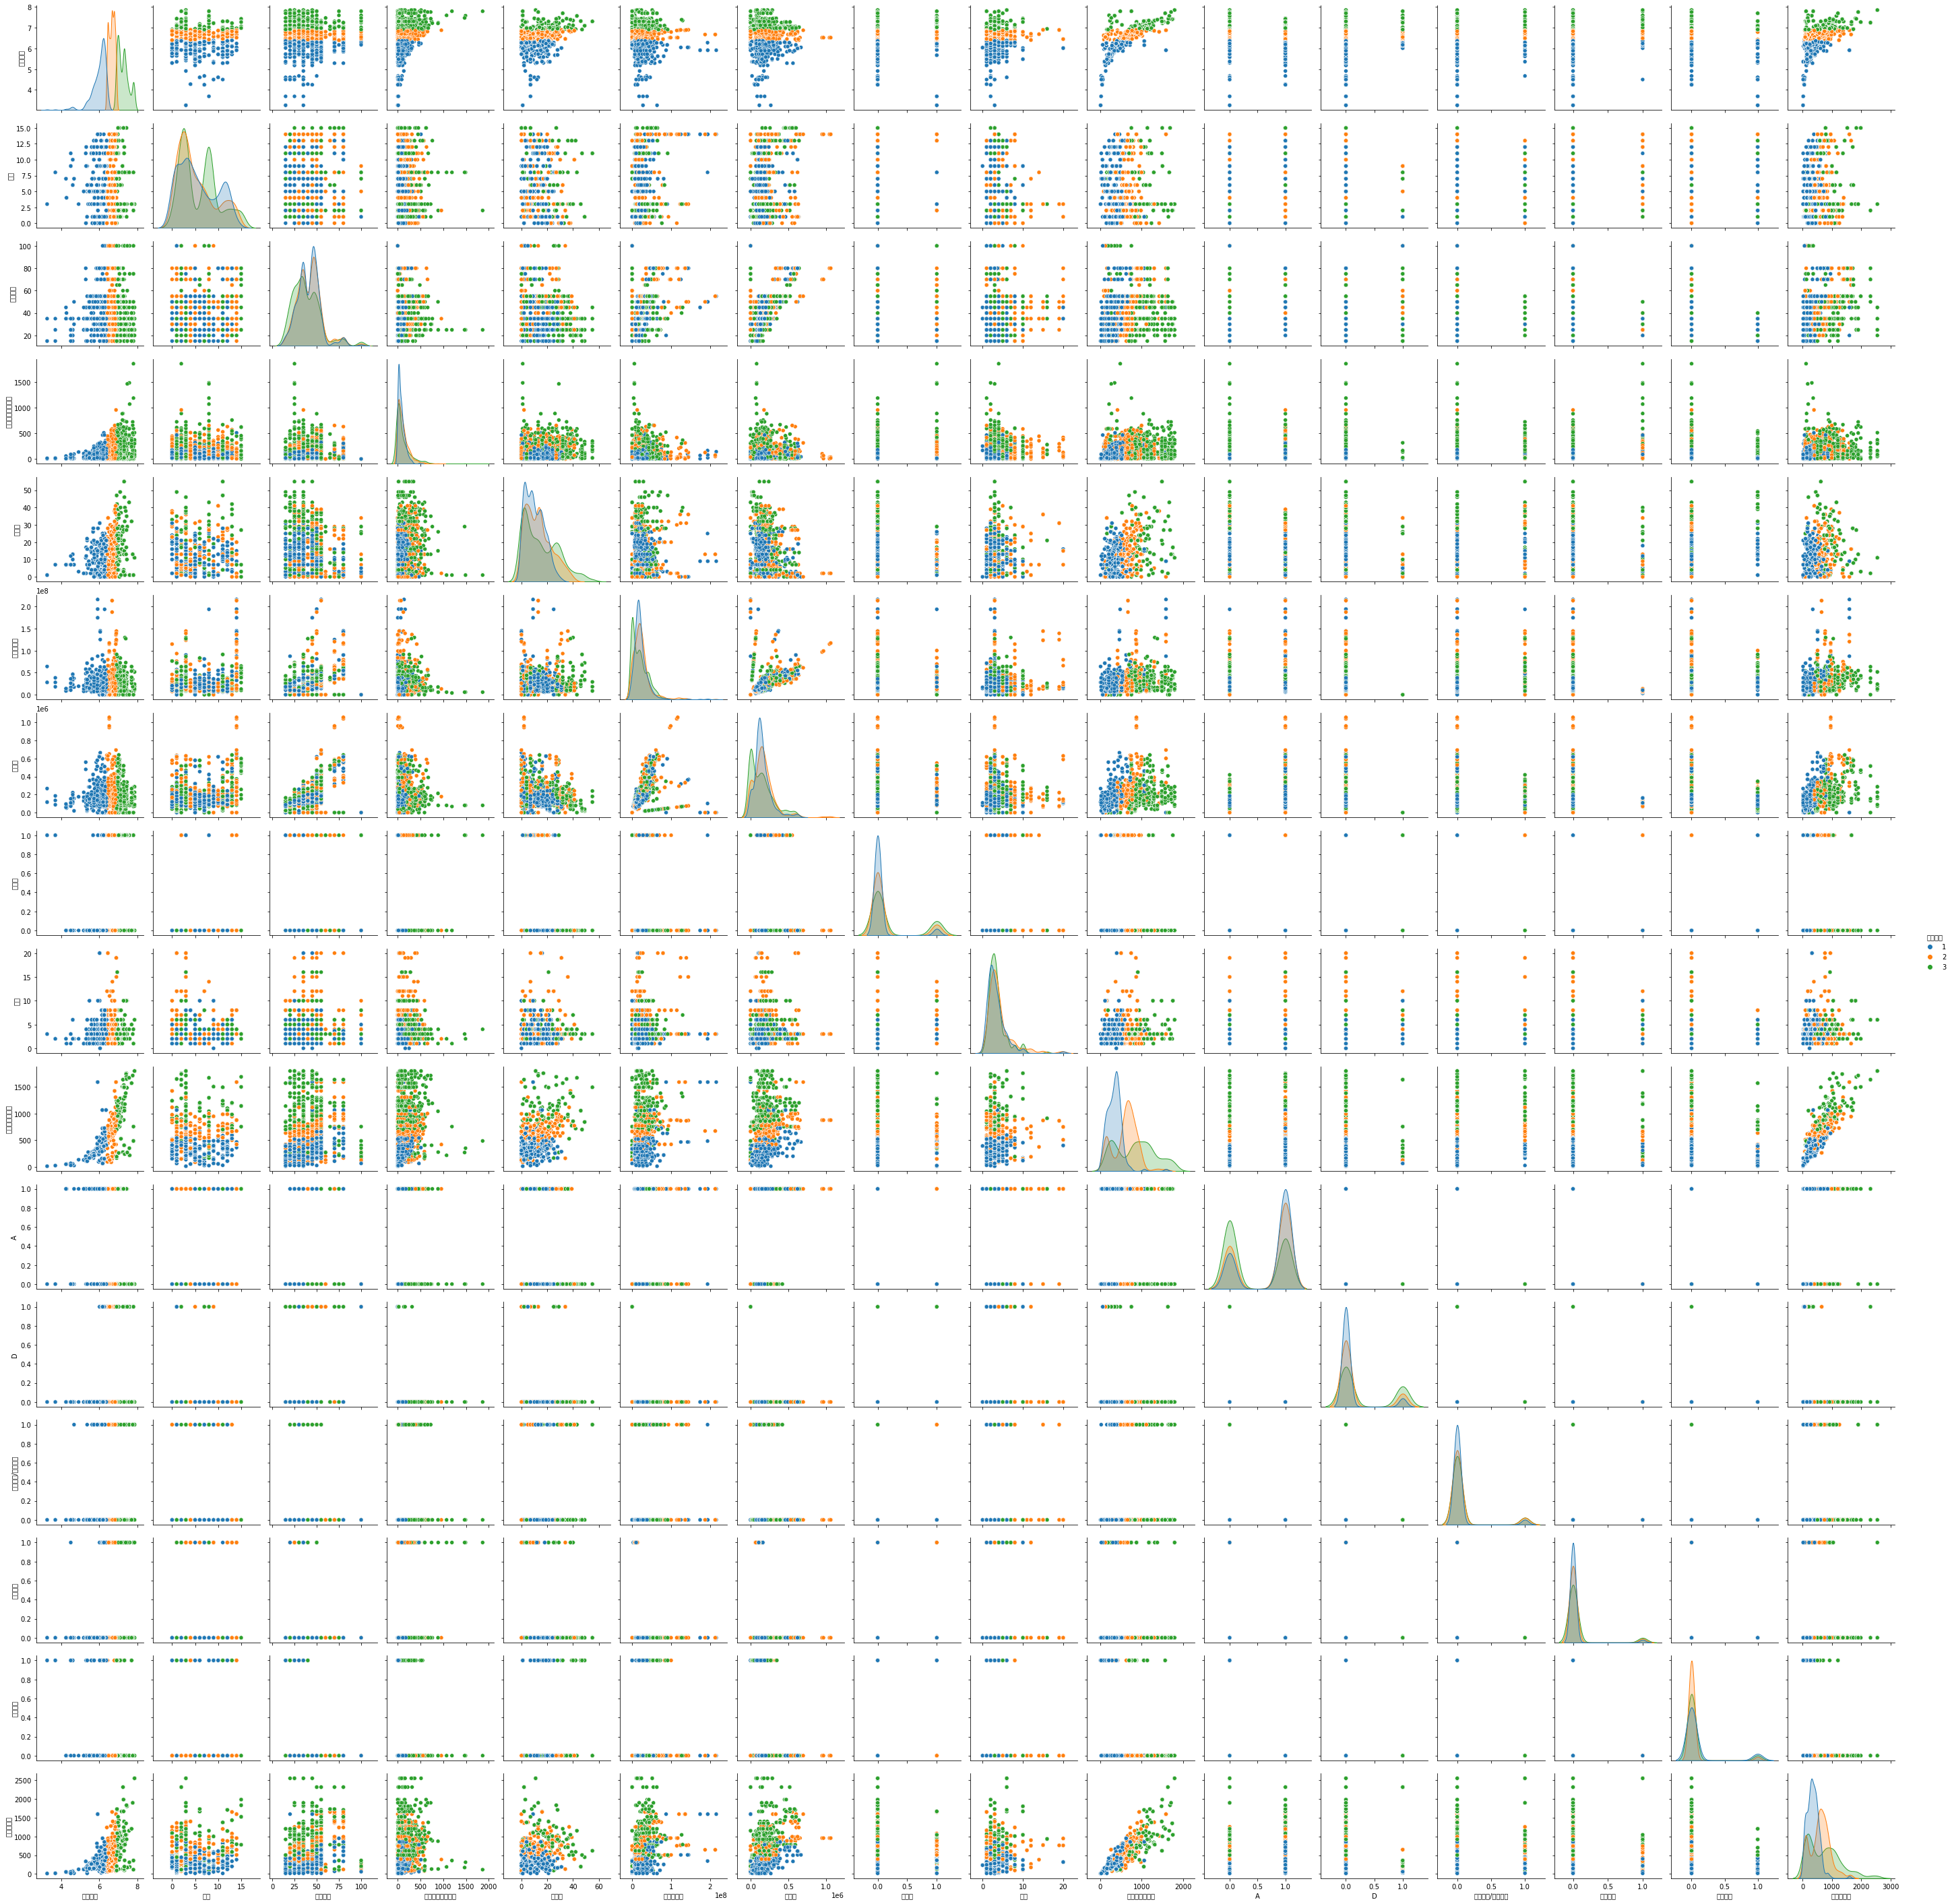

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(train,hue='단지규모')
plt.show()